In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u

pd.options.display.max_columns = 20
pd.options.display.max_rows = 30
pd.options.mode.copy_on_write = True
import warnings
warnings.filterwarnings("ignore")

In [2]:
def amd(m: np.array, e: np.array, i: np.array, a: np.array) -> np.array:
    return m * np.sqrt(a) * (1 - np.sqrt(1 - e**2) * np.cos(np.deg2rad(i)))

def namd(amd: np.array, m: np.array, a: np.array) -> float:
    return np.sum(amd) / np.sum(m * np.sqrt(a))

Load from here ->

In [3]:
df = pd.read_csv("data.csv")
df.index = df["Unnamed: 0"].values
# drop the Unnamed: 0 column
df = df.drop(columns=["Unnamed: 0"])

# df[df["pl_trueobliq"].notnull()][["pl_name", "pl_trueobliq", "pl_trueobliqerr1", "pl_trueobliqerr2"]]

add_index = df.index.max() + 1
df.loc[add_index, 'pl_name'] = 'K2-290 b'
df.loc[add_index, 'hostname'] = 'K2-290'
df.loc[add_index, 'default_flag'] = 1

df.loc[add_index, 'pl_orbsmax'] = 0.0923
df.loc[add_index, 'pl_orbsmaxerr1'] = 0.0
df.loc[add_index, 'pl_orbsmaxerr2'] = 0.0

df.loc[add_index, 'pl_orbincl'] = 88.2
df.loc[add_index, 'pl_orbinclerr1'] = 0.5
df.loc[add_index, 'pl_orbinclerr2'] = -0.6

df.loc[add_index, 'pl_bmasse'] = 10.9041861
df.loc[add_index, 'pl_bmasseerr1'] = 0.0
df.loc[add_index, 'pl_bmasseerr2'] = 0.0

df.loc[add_index, 'pl_trueobliq'] = 127.0
df.loc[add_index, 'pl_trueobliqerr1'] = 0.0
df.loc[add_index, 'pl_trueobliqerr2'] = 0.0

df.loc[add_index, 'sy_pnum'] = 2
df.loc[add_index, 'pl_orbeccen'] = 0.0
df.loc[add_index, 'pl_orbeccenerr1'] = 0.0
df.loc[add_index, 'pl_orbeccenerr2'] = 0.0

df.loc[add_index, 'flag'] = "0"


# adjust the masses of the TOI-942 system planets
idx_toi942b = df[df["pl_name"] == "TOI-942 b"].index[0]
idx_toi942c = df[df["pl_name"] == "TOI-942 c"].index[0]

df.loc[idx_toi942b, "pl_bmasse"] = 16.0
df.loc[idx_toi942c, "pl_bmasse"] = 32.0

# adjust the inclinations of the Kepler-9 system planets

# remove idx 710
df = df.drop(710)

In [4]:
rm_hostnames = []

for hostname in df["hostname"].unique():
    df_host = df[df["hostname"] == hostname]
    # # if df_host contains NaN values, save hostname to a list
    # if df_host.isnull().values.any():
    #     # print(df_host)
    #     rm_hostnames.append(hostname)
    # if df_host contains NaN values in columns different than pl_trueobliq, save hostname to a list
    if df_host.drop(columns=["pl_trueobliq", "pl_trueobliqerr1", "pl_trueobliqerr2"]).isnull().values.any():
        rm_hostnames.append(hostname)

# len(rm_hostnames)
df_clean = df[~df["hostname"].isin(rm_hostnames)]

# remove one hostname which has wrong values in the database ad hoc
df_clean = df_clean[df_clean["hostname"] != "HD 20782"]

# sort the DataFrame by the hostname
df_clean = df_clean.sort_values(by="hostname")

In [5]:
df_clean_stored = df_clean.copy()

In [6]:
maxmass_plnames = []

for hostname in df_clean["hostname"].unique():
    df_host = df_clean[df_clean["hostname"] == hostname]
    
    # take the planet with maximum mass
    maxmass_pl = df_host["pl_bmasse"].idxmax()
    maxmass_plnames.append(hostname)

    # if the obliquity is null for all planets, do this:
    if df_host["pl_trueobliq"].isnull().all():

        df_clean.loc[df_host.index, "pl_relincl"] = \
            df_host.loc[maxmass_pl, "pl_orbincl"] - df_host["pl_orbincl"]
        
        df_clean.loc[df_host.index, "pl_relinclerr1"] = \
            np.sqrt(df_host.loc[maxmass_pl, "pl_orbinclerr1"]**2 + df_host["pl_orbinclerr1"]**2)
        
        df_clean.loc[df_host.index, "pl_relinclerr2"] = \
            np.sqrt(df_host.loc[maxmass_pl, "pl_orbinclerr2"]**2 + df_host["pl_orbinclerr2"]**2)
    elif df_host["pl_trueobliq"].notnull().all():
        # assume the relative inclination is equal to the true obliquity

        df_clean.loc[df_host.index, "pl_relincl"] = df_host["pl_trueobliq"]
        df_clean.loc[df_host.index, "pl_relinclerr1"] = df_host["pl_trueobliqerr1"]
        df_clean.loc[df_host.index, "pl_relinclerr2"] = df_host["pl_trueobliqerr2"]

    # else if we have the obliquity for the most massive planet, we assume that all the planets have the same obliquity
    elif ~np.isnan(df_host.loc[maxmass_pl, "pl_trueobliq"]):
        df_clean.loc[df_host.index, "pl_relincl"] = df_host.loc[maxmass_pl, "pl_trueobliq"]
        df_clean.loc[df_host.index, "pl_relinclerr1"] = df_host.loc[maxmass_pl, "pl_trueobliqerr1"]
        df_clean.loc[df_host.index, "pl_relinclerr2"] = df_host.loc[maxmass_pl, "pl_trueobliqerr2"]

    else:
        print("We should not be here: ", hostname)
        continue

df_clean = df_clean.drop(479)

for hostname in df_clean["hostname"].unique():
    df_host = df_clean[df_clean["hostname"] == hostname]
    
    # calculate the AMD
    amd_val = amd(
        df_host["pl_bmasse"], 
        df_host["pl_orbeccen"], 
        df_host["pl_relincl"], 
        df_host["pl_orbsmax"])
    
    df_clean.loc[df_host.index, "amd"] = amd_val

    # calculate the NAMD
    namd_val = namd(amd_val, df_host["pl_bmasse"], df_host["pl_orbsmax"])

    df_clean.loc[df_host.index, "namd"] = namd_val

df_clean_obliquity = df_clean.copy()

We should not be here:  HAT-P-11
We should not be here:  Kepler-25
We should not be here:  TOI-942
We should not be here:  V1298 Tau


In [7]:
df_clean_obliquity[df_clean_obliquity["hostname"] == "WASP-84"][["pl_name", "pl_relincl", "amd", "namd"]]

,pl_name,pl_relincl,amd,namd
1724,WASP-84 c,17.3,0.215903,0.046974
192,WASP-84 b,17.3,2.770669,0.046974


In [8]:
df_clean_obliquity[df_clean_obliquity["pl_trueobliq"].notnull()][["pl_name", "pl_bmasse", "pl_relincl", "pl_trueobliq", "amd", "namd"]]

,pl_name,pl_bmasse,pl_relincl,pl_trueobliq,amd,namd
1179,HAT-P-11 b,25.743000,NaN,106.0,NaN,0.000000
16822,K2-290 b,10.904186,127.0,127.0,5.306479,1.560207
1312,K2-290 c,246.000420,124.0,124.0,211.829098,1.560207
4277,Kepler-25 c,24.065460,NaN,26.9,NaN,0.000000
3192,Kepler-462 b,53.900000,72.0,72.0,25.617256,0.690983
1884,Kepler-9 b,43.541000,28.1,28.1,1.936046,0.117873
3805,TOI-942 b,16.000000,NaN,2.0,NaN,0.000000
1813,V1298 Tau b,203.410180,NaN,8.0,NaN,0.000000
192,WASP-84 b,220.282500,17.3,17.3,2.770669,0.046974


In [9]:
df_clean = df_clean_stored.copy()

In [10]:
maxmass_plnames = []

for hostname in df_clean["hostname"].unique():
    df_host = df_clean[df_clean["hostname"] == hostname]
    
    # take the planet with maximum mass
    maxmass_pl = df_host["pl_bmasse"].idxmax()
    maxmass_plnames.append(hostname)

    df_clean.loc[df_host.index, "pl_relincl"] = \
        df_host.loc[maxmass_pl, "pl_orbincl"] - df_host["pl_orbincl"]
    
    df_clean.loc[df_host.index, "pl_relinclerr1"] = \
        np.sqrt(df_host.loc[maxmass_pl, "pl_orbinclerr1"]**2 + df_host["pl_orbinclerr1"]**2)
    
    df_clean.loc[df_host.index, "pl_relinclerr2"] = \
        np.sqrt(df_host.loc[maxmass_pl, "pl_orbinclerr2"]**2 + df_host["pl_orbinclerr2"]**2)

df_clean = df_clean.drop(479)

for hostname in df_clean["hostname"].unique():
    df_host = df_clean[df_clean["hostname"] == hostname]
    
    # calculate the AMD
    amd_val = amd(
        df_host["pl_bmasse"], 
        df_host["pl_orbeccen"], 
        df_host["pl_relincl"], 
        df_host["pl_orbsmax"])
    
    df_clean.loc[df_host.index, "amd"] = amd_val

    # calculate the NAMD
    namd_val = namd(amd_val, df_host["pl_bmasse"], df_host["pl_orbsmax"])

    df_clean.loc[df_host.index, "namd"] = namd_val

df_clean_relincl = df_clean.copy()

In [11]:
df_clean_relincl[df_clean_relincl["hostname"] == "WASP-84"][["pl_name", "pl_relincl", "amd", "namd"]]

,pl_name,pl_relincl,amd,namd
1724,WASP-84 c,5.168,0.124535,0.001959
192,WASP-84 b,0.000,0.000000,0.001959


In [12]:
df_clean_relincl[df_clean_relincl["pl_trueobliq"].notnull()][["pl_name", "pl_bmasse", "pl_relincl", "pl_trueobliq", "amd", "namd"]]

,pl_name,pl_bmasse,pl_relincl,pl_trueobliq,amd,namd
1179,HAT-P-11 b,25.743000,45.8800,106.0,1.820951,0.202375
16822,K2-290 b,10.904186,1.1700,127.0,0.000691,0.000005
1312,K2-290 c,246.000420,0.0000,124.0,0.000000,0.000005
4277,Kepler-25 c,24.065460,0.0500,26.9,0.000003,0.001721
3192,Kepler-462 b,53.900000,0.0000,72.0,0.000000,0.000000
1884,Kepler-9 b,43.541000,0.0000,28.1,0.000000,0.000000
3805,TOI-942 b,16.000000,-0.7660,2.0,0.146677,0.022573
1813,V1298 Tau b,203.410180,0.3205,8.0,0.755001,0.040479
192,WASP-84 b,220.282500,0.0000,17.3,0.000000,0.001959


Some plotting

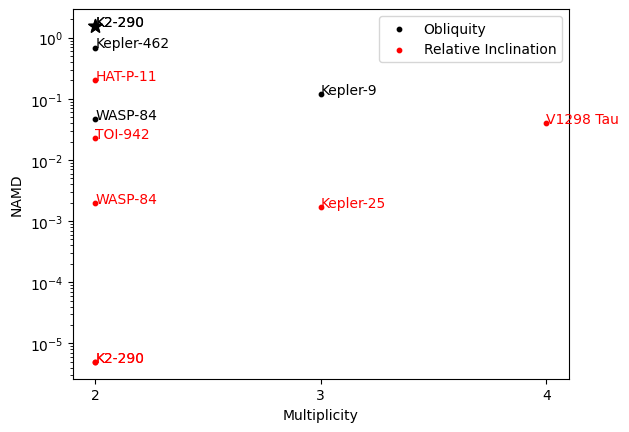

In [20]:
# plot the NAMD vs multiplicity for the planets with obliquity

plt.figure()
idx = df_clean_obliquity["pl_trueobliq"].notnull()
plt.scatter(df_clean_obliquity[idx]["sy_pnum"], df_clean_obliquity[idx]["namd"], c="k", s=10, label="Obliquity")
# write the names of the host stars next to the points
for i, txt in enumerate(df_clean_obliquity[idx]["hostname"]):
    plt.annotate(txt, (df_clean_obliquity[idx]["sy_pnum"].values[i], df_clean_obliquity[idx]["namd"].values[i]), color="k")

# mark with a star the system K2-290
idx = df_clean_obliquity["hostname"] == "K2-290"
plt.scatter(df_clean_obliquity[idx]["sy_pnum"], df_clean_obliquity[idx]["namd"], c="k", s=100, marker="*") #, label="K2-290")

# now for the planets with relative inclination
idx = df_clean_relincl["pl_trueobliq"].notnull()
plt.scatter(df_clean_relincl[idx]["sy_pnum"], df_clean_relincl[idx]["namd"], c="r", s=10, label="Relative Inclination")

# write the names of the host stars next to the points
for i, txt in enumerate(df_clean_relincl[idx]["hostname"]):
    plt.annotate(txt, (df_clean_relincl[idx]["sy_pnum"].values[i], df_clean_relincl[idx]["namd"].values[i]), color="r")

plt.legend()
plt.xlabel("Multiplicity")
plt.ylabel("NAMD")
plt.yscale("log")
plt.xticks(np.arange(2, 5))
plt.show()

In [21]:
df[df["hostname"] == "Kepler-9"]

,pl_name,hostname,default_flag,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,sy_pnum,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,pl_orbincl,pl_orbinclerr1,pl_orbinclerr2,pl_trueobliq,pl_trueobliqerr1,pl_trueobliqerr2,flag
1799,Kepler-9 c,Kepler-9,1.0,0.22715,0.00650,-0.00450,29.90000,2.96600,-3.21600,3.0,0.0,0.00055,-0.00056,89.38,0.0050,-0.0060,NaN,NaN,NaN,0
1806,Kepler-9 d,Kepler-9,1.0,0.02700,0.00042,-0.00043,8.41466,4.18941,-4.18941,3.0,0.0,0.00000,0.00000,89.38,0.0000,0.0000,NaN,NaN,NaN,01+1-3+3-
1884,Kepler-9 b,Kepler-9,1.0,0.14230,0.00400,-0.00350,43.54100,2.70000,-3.30000,3.0,0.0,0.00100,-0.00130,89.38,0.1335,-0.1325,28.1,13.0,-13.6,0
